<a href="https://colab.research.google.com/github/MbProg/AutoTextSum/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


           value  is_anomaly
timestamp                   
1              5           0
2             60           0
3             88           0
4             84           0
5            111           0
Anomaly shape: (5, 2)


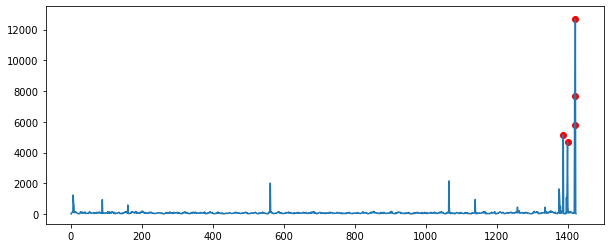

In [3]:
from pandas import read_csv
import matplotlib.pyplot as plt

df = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
print(df.head())
df_anomaly = df.loc[df['is_anomaly']==1.]
print('Anomaly shape:',df_anomaly.shape)
plt.figure(figsize=(10,4))
plt.plot(df.index,df['value'])
plt.scatter(df_anomaly.index, df_anomaly['value'],color='red')
plt.show()

Train shape (938,)  - Test shape: (484,)
Persistent Model RMSE: 867.478
Prediction Test RMSE: 755.167


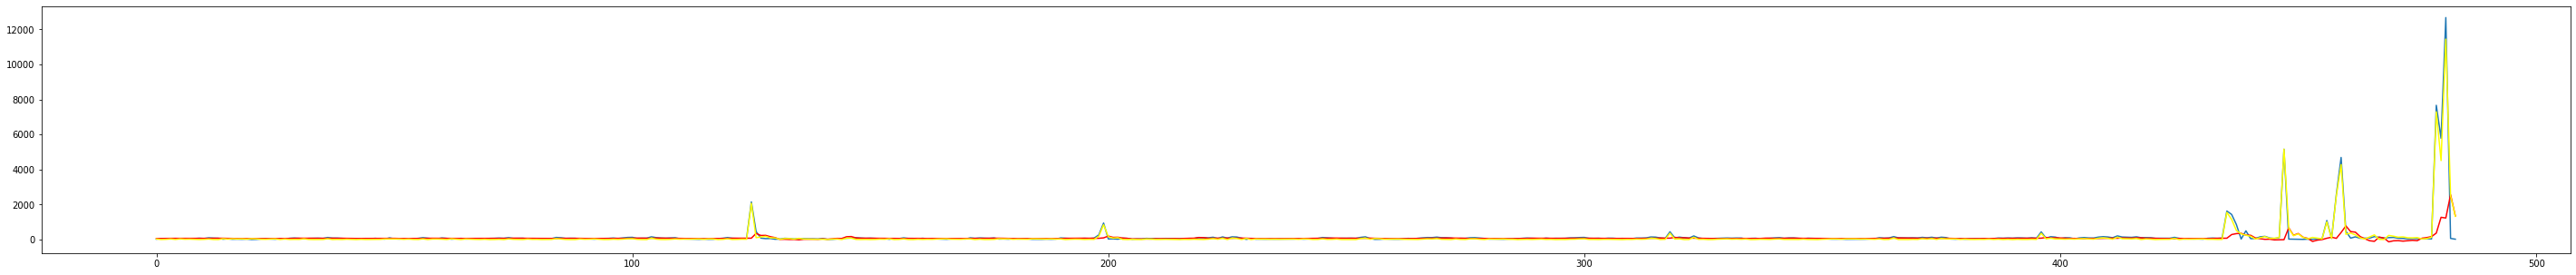

0.0  - FP: 475  - TP: 9  - FPR : 0.981404958677686  - TPR: 1.0
75.46054715348086  - FP: 56  - TP: 8  - FPR : 0.11570247933884298  - TPR: 0.8888888888888888
150.92109430696172  - FP: 27  - TP: 7  - FPR : 0.05578512396694215  - TPR: 0.7777777777777778
226.38164146044258  - FP: 19  - TP: 6  - FPR : 0.03925619834710744  - TPR: 0.6666666666666666
301.84218861392344  - FP: 16  - TP: 5  - FPR : 0.03305785123966942  - TPR: 0.5555555555555556
644.5334653132012  - FP: 10  - TP: 4  - FPR : 0.02066115702479339  - TPR: 0.4444444444444444
2496.5340125221496  - FP: 4  - TP: 3  - FPR : 0.008264462809917356  - TPR: 0.3333333333333333
4509.455404637594  - FP: 2  - TP: 2  - FPR : 0.004132231404958678  - TPR: 0.2222222222222222
11441.589124627042  - FP: 0  - TP: 1  - FPR : 0.0  - TPR: 0.1111111111111111


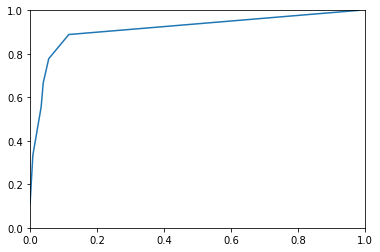

AUC:  0.8961202938475666


In [56]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class AR_Compact:

    def model_persistence(self, x):
        return x

    def create_persistence(self):
        predictions = list()
        for x in self.test_X:
            yhat = self.model_persistence(x)
            predictions.append(yhat)
        rmse = sqrt(mean_squared_error(self.test_y, predictions))
        print('Train shape', self.train_X.shape, ' - Test shape:' , self.test_X.shape)
        print('Persistent Model RMSE: %.3f' % rmse)        


    def __init__(self, path, train_rate):
        df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = pd.DataFrame(df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']

        self.train_size = int(len(self.values) * train_rate)

        self.train, self.test = self.dataframe.values[1:self.train_size], self.dataframe.values[self.train_size:]
        self.train_X, self.train_y = self.train[:,0], self.train[:,1]
        self.test_X, self.test_y = self.test[:,0], self.test[:,1]     
        self.create_persistence()

        X = series.values
        self.train, self.test = X[1:self.train_size], X[self.train_size:]

          
    def fit(self, verbose=False):
        self.model = AR(self.train)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params  
        if verbose:      
            print('Lag: %s' % self.model_fit.k_ar)
            print('Coefficients: %s' % self.model_fit.params)

    
    def predict(self):
        self.history = self.train[len(self.train)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test)):
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            yhat = self.coef[0]
            for d in range(self.window):
                yhat += self.coef[d+1] * lag[self.window-d-1]
            obs = self.test[t]
            self.predictions.append(yhat)
            self.history.append(obs)        
        # for i in range(len(predictions)):
        #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
        rmse = sqrt(mean_squared_error(self.test, self.predictions))
        self.errors = np.absolute(self.test - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,5))
        pyplot.plot(self.test)
        pyplot.plot(self.predictions, color='red')
        pyplot.plot(self.errors, color = 'yellow')
        pyplot.show()

    def get_roc_auc(self, plot=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[df[df['is_anomaly']==1].index - self.train_size]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],5)[:-1],true_anomaly_predicted_errors]
        # true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            print(threshold,' - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )
ar_model = AR_Compact('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', 0.66)
ar_model.fit()
ar_model.predict()
ar_model.plot()
ar_model.get_roc_auc()

## MA Model

Prediction Test RMSE: 729.709


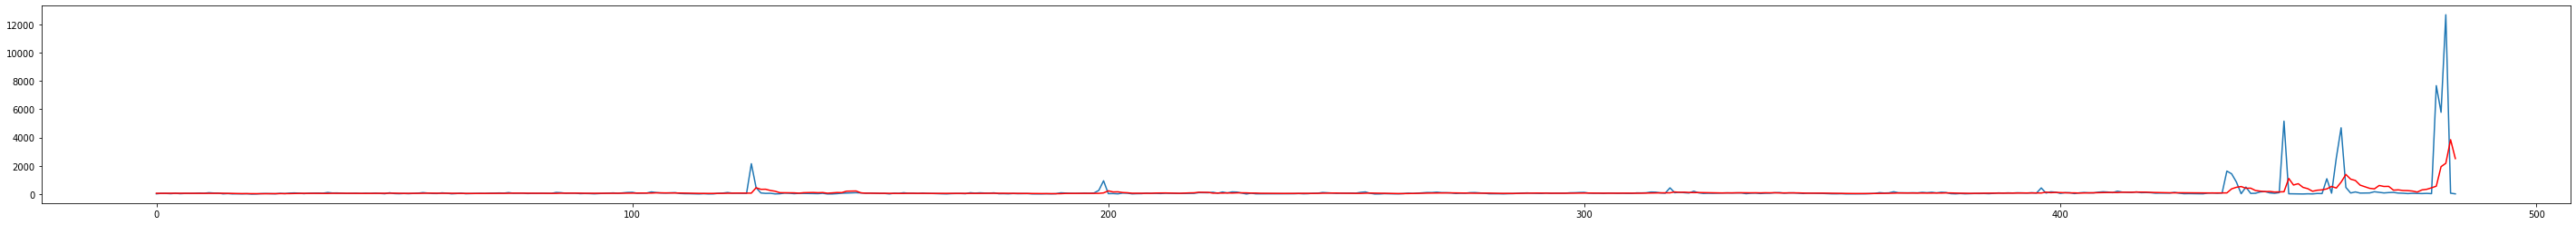

Threshold:                       0.0  - FP:  475 - TP:    9 - FPR:     0.981404958677686 - TPR:  1.0
Threshold:         228.6202595078512  - FP:   32 - TP:    8 - FPR:   0.06611570247933884 - TPR: 0.8888888888888888
Threshold:         457.2405190157024  - FP:   18 - TP:    7 - FPR:    0.0371900826446281 - TPR: 0.7777777777777778
Threshold:         685.8607785235536  - FP:   12 - TP:    6 - FPR:  0.024793388429752067 - TPR: 0.6666666666666666
Threshold:         914.4810380314048  - FP:    9 - TP:    5 - FPR:   0.01859504132231405 - TPR: 0.5555555555555556
Threshold:        1080.3220362057964  - FP:    7 - TP:    4 - FPR:  0.014462809917355372 - TPR: 0.4444444444444444
Threshold:         3779.724359843225  - FP:    3 - TP:    3 - FPR:  0.006198347107438017 - TPR: 0.3333333333333333
Threshold:         3839.464965751371  - FP:    3 - TP:    2 - FPR:  0.006198347107438017 - TPR: 0.2222222222222222
Threshold:        10492.930742339307  - FP:    0 - TP:    1 - FPR:                   0.0 - TPR

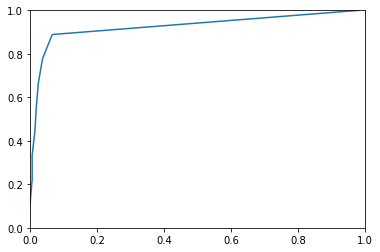

AUC:  0.9075987144168962


In [55]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import read_csv
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
from matplotlib import pyplot

class MA:
    i = 12345
    def __init__(self, path, train_rate):

        df = read_csv(path, header=0, index_col=0, parse_dates=True,squeeze=True)
        series = pd.DataFrame(df.iloc[:,0].values)  
        self.values = DataFrame(series.values)
        self.dataframe = concat([self.values.shift(1), self.values], axis=1)
        self.dataframe.columns = ['t', 't+1']
        X = self.dataframe.values

        self.train_size = int(len(X) * train_rate)    

        train, test = X[1:self.train_size], X[self.train_size:]
        self.train_X, self.train_y = train[:,0], train[:,1]
        self.test_X, self.test_y = test[:,0], test[:,1]        
        # persistence model on training set
        self.train_pred = [x for x in self.train_X]
        # calculate residuals
        self.train_resid = [self.train_y[i]-self.train_pred[i] for i in range(len(self.train_pred))]

    def fit(self, verbose=False):
        self.model = AR(self.train_resid)
        self.model_fit = self.model.fit()
        self.window = self.model_fit.k_ar
        self.coef = self.model_fit.params        
        if verbose:
            print(self.coef)

    def predict(self):
        # walk forward over time steps in test
        self.history = self.train_resid[len(self.train_resid)-self.window:]
        self.history = [self.history[i] for i in range(len(self.history))]
        self.predictions = list()
        for t in range(len(self.test_y)):
            # persistence
            yhat = self.test_X[t]
            error = self.test_y[t] - yhat
            # predict error
            length = len(self.history)
            lag = [self.history[i] for i in range(length-self.window,length)]
            pred_error = self.coef[0]
            for d in range(self.window):
                pred_error += self.coef[d+1] * lag[self.window-d-1]
            # correct the prediction
            yhat = yhat + pred_error
            self.predictions.append(yhat)
            self.history.append(error)
            # print('predicted=%f, expected=%f' % (yhat, test_y[t]))
        rmse = sqrt(mean_squared_error(self.test_y, self.predictions))
        self.errors = np.absolute(self.test_y - np.array(self.predictions))
        print('Prediction Test RMSE: %.3f' % rmse)

    def plot(self):
        # plot predicted error
        pyplot.figure(figsize=(50,4))
        pyplot.plot(self.test_y)
        pyplot.plot(self.predictions, color='red')
        pyplot.show()       

    def get_roc_auc(self, plot=True):
        # get the predicted errors of the anomaly points
        true_anomaly_predicted_errors = self.errors[df[df['is_anomaly']==1].index - self.train_size]
        # sort them 
        true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
        true_anomaly_predicted_errors = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],5)[:-1],true_anomaly_predicted_errors]
        # true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
        # now iterate thru the predicted errors from small to big
        # for each value look how much other points have equal or bigger error
        FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
        TPR = [] # tp/p
        p = len(true_anomaly_predicted_errors)
        Thresholds = []
        for predictederror in true_anomaly_predicted_errors:
            threshold = predictederror
            tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
            fp = len(self.errors[self.errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
            
            fpr =fp/len(self.errors)
            FPR.append(fpr)
            TPR.append(tp/p)
            print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

            # print('Threshold: ' , threshold,'\t\t\t\t - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

        import matplotlib.pyplot as plt
        if plot:
            plt.figure()
            plt.axis([0, 1, 0, 1])
            plt.plot(FPR,TPR)
            plt.show() 

        # This is the AUC
        from sklearn.metrics import auc
        print('AUC: ' ,auc(FPR,TPR)        )

ma_model = MA('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv',0.66)
ma_model.fit()
ma_model.predict()
ma_model.plot()
ma_model.get_roc_auc()

## ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                 1422
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10603.704
Method:                       css-mle   S.D. of innovations            418.686
Date:                Fri, 15 Nov 2019   AIC                          21221.408
Time:                        06:35:29   BIC                          21258.226
Sample:                             1   HQIC                         21235.161
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1722      3.596      0.604      0.546      -4.877       9.221
ar.L1.D.value    -0.5066      0.027    -18.602      0.000      -0.560      -0.453
ar.L2.D.value    -0.1631      0.035     

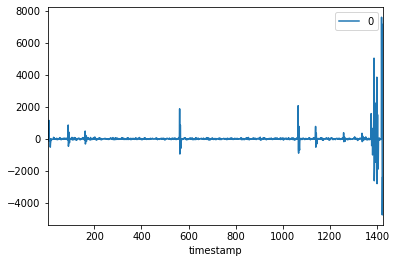

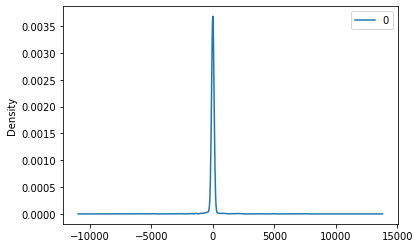

                 0
count  1422.000000
mean      0.081439
std     418.836221
min   -4771.157431
25%     -28.206922
50%      -8.651336
75%      11.923210
max    7610.316453


In [13]:
# fit an ARIMA model and plot residual errors
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
# load dataset
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True).iloc[:,0]
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

483:484Test RMSE: 866.259


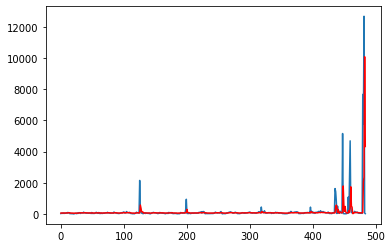

In [26]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
# load dataset
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,
squeeze=True).iloc[:,0]
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,0,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  sys.stdout.write('\r'+str(t)+':'+str(len(test)))
  # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [34]:
test.shape,np.array(predictions).shape, errors.shape

((484,), (484, 1), (484, 484))

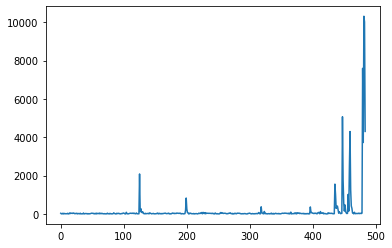

In [36]:
errors = np.absolute(test - np.array(predictions).reshape(-1))
plt.plot(errors)
plt.show()

Threshold:                       0.0  - FP:  475 - TP:    9 - FPR:     0.981404958677686 - TPR:  1.0
Threshold:        315.91349830604645  - FP:   14 - TP:    8 - FPR:  0.028925619834710745 - TPR: 0.8888888888888888
Threshold:         631.8269966120929  - FP:    8 - TP:    7 - FPR:   0.01652892561983471 - TPR: 0.7777777777777778
Threshold:         947.7404949181393  - FP:    8 - TP:    6 - FPR:   0.01652892561983471 - TPR: 0.6666666666666666
Threshold:        1263.6539932241858  - FP:    7 - TP:    5 - FPR:  0.014462809917355372 - TPR: 0.5555555555555556
Threshold:        1765.7694627725994  - FP:    6 - TP:    4 - FPR:  0.012396694214876033 - TPR: 0.4444444444444444
Threshold:        3723.9635493674573  - FP:    4 - TP:    3 - FPR:  0.008264462809917356 - TPR: 0.3333333333333333
Threshold:         10010.76155364231  - FP:    0 - TP:    2 - FPR:                   0.0 - TPR: 0.2222222222222222
Threshold:        10311.038610976186  - FP:    0 - TP:    1 - FPR:                   0.0 - TPR

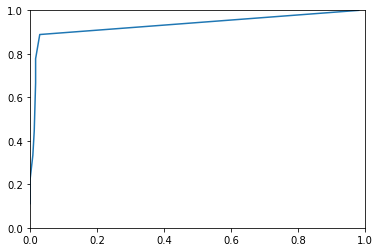

AUC:  0.9160927456382002


In [57]:
plot = True
train_size = size
# get the predicted errors of the anomaly points
true_anomaly_predicted_errors = errors[df[df['is_anomaly']==1].index - train_size]
# sort them 
true_anomaly_predicted_errors = np.sort(true_anomaly_predicted_errors,axis=0).reshape(-1)
true_anomaly_predicted_errors = np.r_[np.linspace(0,true_anomaly_predicted_errors[0],5)[:-1],true_anomaly_predicted_errors]
# true_anomaly_predicted_errors_extended = np.r_[np.array([0]),true_anomaly_predicted_errors,np.array([1000000])]
# now iterate thru the predicted errors from small to big
# for each value look how much other points have equal or bigger error
FPR = [] # fp/n  https://en.wikipedia.org/wiki/Sensitivity_and_specificity
TPR = [] # tp/p
p = len(true_anomaly_predicted_errors)
Thresholds = []
for predictederror in true_anomaly_predicted_errors:
    threshold = predictederror
    tp = len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>= threshold])
    fp = len(errors[errors>=threshold])-len(true_anomaly_predicted_errors[true_anomaly_predicted_errors>=threshold])
    
    fpr =fp/len(errors)
    FPR.append(fpr)
    TPR.append(tp/p)
    print("Threshold: {0:25}  - FP: {1:4} - TP: {2:4} - FPR: {3:21} - TPR: {4:4}".format(threshold,fp, tp, fpr, tp/p))

    # print('Threshold: ' , threshold,'\t\t\t\t - FP:', fp,' - TP:',tp, ' - FPR :' ,fpr,' - TPR:', tp/p)

import matplotlib.pyplot as plt
if plot:
    plt.figure()
    plt.axis([0, 1, 0, 1])
    plt.plot(FPR,TPR)
    plt.show() 

# This is the AUC
from sklearn.metrics import auc
print('AUC: ' ,auc(FPR,TPR)        )

In [59]:
df.iloc[:,0]

timestamp
1           5
2          60
3          88
4          84
5         111
        ...  
1419     7665
1420     5781
1421    12673
1422       67
1423       22
Name: value, Length: 1423, dtype: int64

In [0]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_arima_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
def parser(x):
  return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True).iloc[:,0]
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)    

ARIMA(0, 0, 0) RMSE=804.962
ARIMA(0, 0, 1) RMSE=777.875
ARIMA(0, 0, 2) RMSE=760.593
ARIMA(0, 1, 0) RMSE=867.788
ARIMA(0, 1, 1) RMSE=833.645
ARIMA(0, 1, 2) RMSE=892.816
ARIMA(0, 2, 0) RMSE=1456.990
ARIMA(0, 2, 1) RMSE=868.480
ARIMA(1, 0, 0) RMSE=839.491
ARIMA(1, 1, 0) RMSE=878.006
ARIMA(1, 1, 1) RMSE=927.167
ARIMA(1, 1, 2) RMSE=944.799
ARIMA(1, 2, 0) RMSE=1011.961
ARIMA(2, 0, 0) RMSE=870.224
ARIMA(2, 1, 0) RMSE=912.469
ARIMA(2, 1, 1) RMSE=886.938
ARIMA(2, 2, 0) RMSE=1044.434
ARIMA(4, 0, 0) RMSE=864.136
ARIMA(4, 0, 1) RMSE=866.523
ARIMA(4, 1, 0) RMSE=896.127


In [0]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

483:484Test RMSE: 2833.230


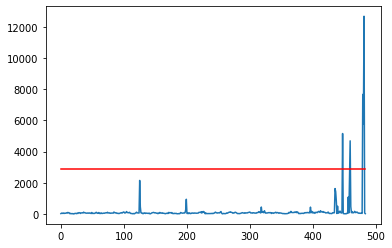

In [12]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import sys# Simple Exponential Smoothing

series = read_csv('drive/My Drive/MT/Experiments/Univariate/YahooServiceNetworkTraffic/A1Benchmark/real_4.csv', header=0, index_col=0, parse_dates=True,squeeze=True).iloc[:,0]

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
warnings.filterwarnings("ignore")

for t in range(len(test)):
  fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.2,optimized=False)
  output = fit1.forecast(1).iloc[0]
  yhat = output
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  sys.stdout.write('\r'+str(t)+':'+str(len(test)))
  # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


# fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.2,optimized=False)
# fcast1 = fit1.forecast(12).rename(r'$\alpha=0.2$')
# # plot
# fcast1.plot(marker='o', color='blue', legend=True)
# fit1.fittedvalues.plot(marker='o',  color='blue')

In [7]:
fit1.forecast().iloc[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2884.000954300706